In [1]:
# CELL 0: Install Libraries
%pip install pandas numpy scikit-learn matplotlib seaborn joblib xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# CELL 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import xgboost as xgb

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics & Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


In [6]:
# CELL 2: Load and Combine Data

train_path = "./nids/train.csv"
test_path = "./nids/test.csv"
cols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

# 1. Load the file normally first
df1 = pd.read_csv(train_path)
df2 = pd.read_csv(test_path)

# 2. SANITY CHECK: Did we load the header as a data row?
# If the first cell contains the word "duration", we loaded it wrong.
if str(df1.iloc[0,0]) == "duration":
    print("Detected header inside data. Reloading with header=1...")
    df1 = pd.read_csv(train_path, header=1)
    df2 = pd.read_csv(test_path, header=1)
    # Ensure columns are named correctly
    df1.columns = cols
    df2.columns = cols
else:
    # If the columns are not named "duration" (e.g. "0", "1"), fix them
    if df1.columns[0] != "duration":
        print("File has no headers. Adding headers...")
        df1.columns = cols
        df2.columns = cols

# 3. Combine
print(f"Train Shape: {df1.shape}")
print(f"Test Shape:  {df2.shape}")
df = pd.concat([df1, df2], axis=0)

# 4. CRITICAL VERIFICATION
# This must NOT show words like 'duration' or 'protocol_type' in the rows
print("\nVERIFICATION (First 3 rows of data):")
# We check the 'duration' column. It MUST be a number (0, 1, etc.)
print(df[['duration', 'protocol_type', 'src_bytes']].head(3))

# Final check to ensure no strings in number columns
if not np.issubdtype(df['duration'].dtype, np.number):
    print("\nFATAL ERROR: 'duration' column is still text! Cleaning...")
    # Force convert to numeric, turning errors (strings) into NaN
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    # Drop the bad rows
    df.dropna(subset=['duration'], inplace=True)
    print("Bad rows removed.")

print(f"Final Combined Data: {df.shape}")

Train Shape: (125973, 43)
Test Shape:  (22544, 43)

VERIFICATION (First 3 rows of data):
   duration protocol_type  src_bytes
0         0           tcp        491
1         0           udp        146
2         0           tcp          0
Final Combined Data: (148517, 43)


In [7]:
# CELL 3: Preprocessing

# 1. Remove Garbage
if 'difficulty_level' in df.columns:
    df.drop('difficulty_level', axis=1, inplace=True)

# 2. Binary Labeling (0 = Normal, 1 = Attack)
# We map 'normal' to 0 and EVERYTHING else to 1
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# 3. Encoding (Text -> Numbers)
# We use LabelEncoding for Protocol, Service, and Flag
cat_cols = ['protocol_type', 'service', 'flag']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# 4. Final Split (80% Train, 20% Test)
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data Processed & Split.")
print(f"Training on: {X_train.shape[0]} packets")
print(f"Testing on:  {X_test.shape[0]} packets")

Data Processed & Split.
Training on: 118813 packets
Testing on:  29704 packets


In [8]:
# CELL 4: Model Competition

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
trained_models = {}

print("Starting Training Loop...\n")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) # How many attacks we found
    f1 = f1_score(y_test, y_pred)
    
    results.append({"Model": name, "Accuracy": acc, "Attack Recall": rec, "F1 Score": f1})
    trained_models[name] = model
    
    # Quick Report
    print(f"Accuracy: {acc*100:.2f}% | Attack Recall: {rec*100:.2f}%")

# Show Leaderboard
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

Starting Training Loop...

Training Decision Tree...
Accuracy: 99.19% | Attack Recall: 98.94%
Training Random Forest...
Accuracy: 99.61% | Attack Recall: 99.46%
Training XGBoost...
Accuracy: 99.65% | Attack Recall: 99.51%


,Model,Accuracy,Attack Recall,F1 Score
2,XGBoost,0.996532,0.995102,0.996392
1,Random Forest,0.996095,0.994613,0.995937
0,Decision Tree,0.991920,0.989365,0.991585


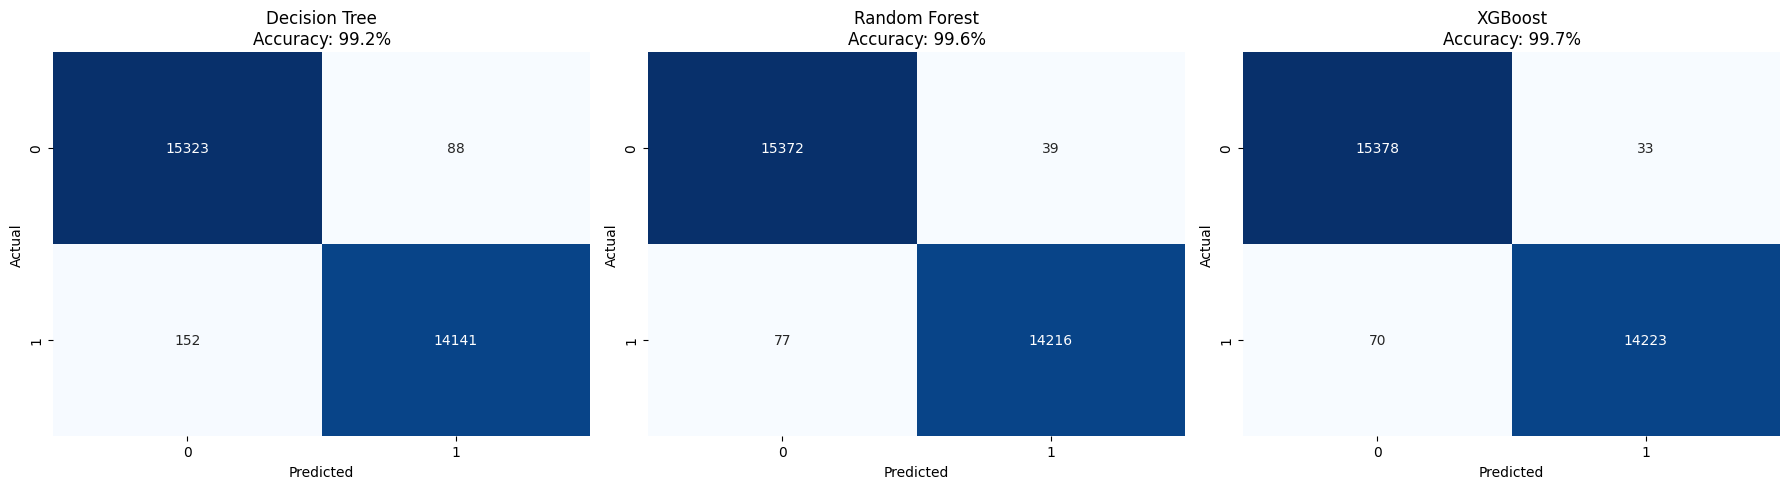

In [9]:
# CELL 5: Visualization

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(trained_models.items()):
    plt.subplot(1, 3, i+1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name}\nAccuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [11]:
# CELL 6: Auto-Save Best Model

# Pick the top model from the leaderboard
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print(f"WINNER: {best_model_name}")

# Save
joblib.dump(best_model, "./nids/nids_model.pkl")
joblib.dump(encoders, "./nids/encoders.pkl")

print("Best model saved successfully!")

WINNER: XGBoost
Best model saved successfully!
